Pet Classification.zip Pet Classification.zip


Reading images and labels...
Extracting features...


Processing Images: 100%|████████████████████████████████████████████████████████| 10000/10000 [00:53<00:00, 187.30it/s]


Epoch 1/20


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4995 - loss: 0.8322
Epoch 1: val_accuracy improved from -inf to 0.56700, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1139s 4s/step - accuracy: 0.4995 - loss: 0.8321 - val_accuracy: 0.5670 - val_loss: 0.6806 - learning_rate: 1.0000e-05
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5194 - loss: 0.7694
Epoch 2: val_accuracy improved from 0.56700 to 0.66350, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1200s 5s/step - accuracy: 0.5194 - loss: 0.7694 - val_accuracy: 0.6635 - val_loss: 0.6446 - learning_rate: 1.0000e-05
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5578 - loss: 0.7297
Epoch 3: val_accuracy improved from 0.66350 to 0.77600, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1003s 4s/step - accuracy: 0.5578 - loss: 0.7297 - val_accuracy: 0.7760 - val_loss: 0.5982 - learning_rate: 1.0000e-05
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step 

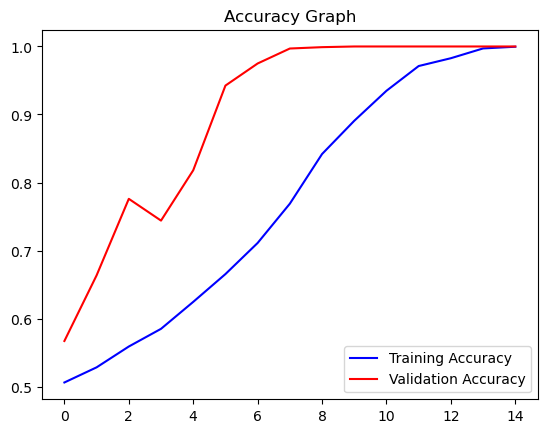

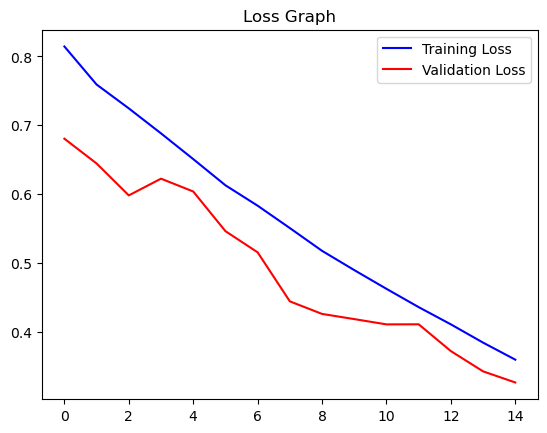

Enter the index of the image for prediction:  600


Original Label: Cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
Predicted Label: Cat


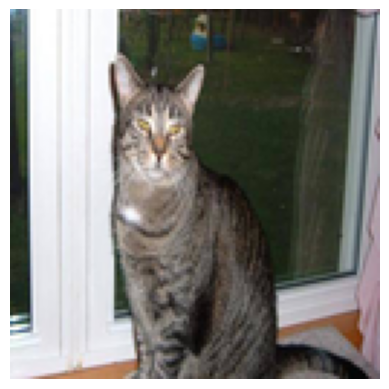

In [6]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf


def read_images_and_labels_from_folder(folder_path, max_images=10000):
    """Read images and labels from the folder"""
    image_paths = []
    labels = []
    image_count = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')) and image_count < max_images:
                file_path = os.path.join(root, file)
                label = 0 if 'cat' in file.lower() else 1
                image_paths.append(file_path)
                labels.append(label)
                image_count += 1
            if image_count >= max_images:
                break
        if image_count >= max_images:
            break

    return image_paths, labels


def extract_features(image_paths):
    """Extract features from images"""
    features = []
    for path in tqdm(image_paths, desc="Processing Images"):
        try:
            image = Image.open(path)
            image = image.resize((128, 128), Image.LANCZOS)
            img_array = np.array(image)
            if img_array.shape == (128, 128, 3):  # Ensure consistent shape
                features.append(img_array)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    features = np.array(features)
    features = features / 255.0  # Normalize
    return features


def extract_zip(zip_file_path, extract_to_path):
    """Extract zip file"""
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)


def main():
    zip_file_path = input("Pet Classification.zip")
    extract_to_path = 'dataset'
    os.makedirs(extract_to_path, exist_ok=True)

    # Extract the zip file
    extract_zip(zip_file_path, extract_to_path)

    # Reading the images and labels from the extracted folder
    dataset_folder_path = extract_to_path
    print("Reading images and labels...")
    image_paths, labels = read_images_and_labels_from_folder(dataset_folder_path, max_images=10000)

    # Extract features from the images
    print("Extracting features...")
    X = extract_features(image_paths)
    y = np.array(labels)

    # Split dataset (stratified split to maintain class balance)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Calculate class weights for imbalance in the classes
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Data Augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

    # Load Pretrained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Fine-tune the top layers of the VGG16 model
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Build the model
    inputs = Input((128, 128, 3))
    x = base_model(inputs, training=True)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    # Define Callbacks
    checkpoint_path = 'best_model.keras'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    # Load the best model
    model = load_model(checkpoint_path)

    # Plot Accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Accuracy Graph')
    plt.legend()
    plt.show()

    # Plot Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

    # Predict on a single image
    image_index = int(input("Enter the index of the image for prediction: "))
    label_dict = {0: 'Cat', 1: 'Dog'}
    print("Original Label:", label_dict[y[image_index]])

    pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
    pred_label = label_dict[round(pred[0][0])]
    print("Predicted Label:", pred_label)

    plt.imshow(X[image_index].reshape(128, 128, 3))
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    main()